In [ ]:
# Install required libs

### please update Albumentations to version>=0.3.0 for `Lambda` transform support
!pip install albumentations>=0.3.0
!pip install segmentation-models
#!pip install keras_applications>=1.0.7,<=1.0.8
#!pip install image-classifiers==1.0.0
#!pip install efficientnet==1.0.0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 7.2 MB/s 


In [ ]:
%%capture
#!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
!pip install pytorch-lightning
!pip install torchmetrics
!pip install segmentation-models-pytorch
!pip install einops
!pip install -U tqdm
!pip install -U albumentations
import pytorch_lightning
import segmentation_models_pytorch
import torchmetrics
import einops
import tqdm
import albumentations
import os
import torch
import matplotlib.pyplot as plt
import tqdm
from torch.nn import functional as F
import albumentations as A
from albumentations.pytorch import ToTensorV2
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
from pytorch_lightning.callbacks import EarlyStopping,ModelCheckpoint,LearningRateMonitor
from pprint import pprint
from torch.utils. data import DataLoader
from glob import glob
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,Dataset
import cv2
import numpy as np
import torchvision
from PIL import Image
import torchmetrics

In [ ]:
import os
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import imageio
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [ ]:
class HuyModel:
  def __init__(self):
      BACKBONES = ['resnet34','inceptionresnetv2']
      self.PATH=[
          '/content/drive/MyDrive/Kaggle/Dataset/seperated/PSPNet/best_model-resnet34-flip.h5',
          #'/content/drive/MyDrive/Kaggle/Dataset/seperated/best_model-vgg19.h5',
          '/content/drive/MyDrive/Kaggle/Dataset/seperated/PSPNet/inceptionresnetv2-20epoch-lrs-v1'
          #'/content/drive/MyDrive/Kaggle/Dataset/seperated/PSPNet/best_model-resnet34.h5'
            ]
      self.keys=[1,
          #  -1,
            1]
      self.points=[
          1,
         # 1,
          1,
      ]
      CLASSES = ['human']
      LR=0.0001
      #preprocess_input = sm.get_preprocessing(BACKBONE)
      self.preprocess_input=[sm.get_preprocessing(BACKBONE) for BACKBONE in BACKBONES]
      # define network parameters
      n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
      activation = 'sigmoid' if n_classes == 1 else 'softmax'

      #create model

      # define optomizer
      optim = keras.optimizers.Adam(LR)

      # Segmentation models losses can be combined together by '+' and scaled by integer or float factor
      dice_loss = sm.losses.DiceLoss()
      focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
      #total_loss = dice_loss + (1 * focal_loss)

      # actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
      total_loss = sm.losses.binary_focal_dice_loss
      #total_loss = sm.losses.categorical_focal_dice_loss 

      metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

      # compile keras model with defined optimozer, loss and metrics
      self.model = [sm.PSPNet(BACKBONE, classes=n_classes, activation=activation)for BACKBONE in BACKBONES]
      for i in range(len(BACKBONES)):
        self.model[i].compile(optim, total_loss, metrics)
        self.model[i].load_weights(self.PATH[i])
  def predict(self,img,visual=False):
        try:
          img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        except:
          pass
        img = cv2.resize(img, [384,384])
        img0=img.copy()
        tempo=self.model[0].predict( np.expand_dims(self.preprocess_input[0](img0),axis=0),verbose=0)
        result=(tempo)/np.max(tempo)*self.points[0]
        #result=cutBot(r)
        masks=[]
        masks.append(result)
        for i in range(1,len(self.PATH)):
          img0=img.copy()
          tempo=self.model[i].predict( np.expand_dims(self.preprocess_input[i](img0),axis=0),verbose=0)
          if(self.keys[i]==-1):
            tempo=(np.max(tempo)-tempo)/np.max(tempo)
          else:
            tempo=tempo-np.min(tempo)
            tempo=(tempo)/np.max(tempo)

          tempo=tempo*self.points[i]  
          masks.append(tempo)
          result+=tempo
        visualize(
            mask0=masks[0].squeeze(),
            mask1=masks[1].squeeze(),
            #mask2=masks[2].squeeze()
            )
        return result
Huymodel=HuyModel()

219055592/219055592 [==============================] - 2s 0us/step


In [ ]:
class KhangModel:
  def __init__(self):
      BACKBONES = ['resnet34']
      self.PATH=[
          '/content/drive/MyDrive/Kaggle/Dataset/seperated/FPN3.h5'
          #'/content/drive/MyDrive/Kaggle/Dataset/seperated/PSPNet/best_model-resnet34.h5'
            ]
      self.keys=[-1]
      self.points=[1]
      CLASSES = ['human']
      LR=0.0001
      #preprocess_input = sm.get_preprocessing(BACKBONE)
      self.preprocess_input=[sm.get_preprocessing(BACKBONE) for BACKBONE in BACKBONES]
      # define network parameters
      n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
      activation = 'sigmoid' if n_classes == 1 else 'softmax'

      #create model

      # define optomizer
      optim = keras.optimizers.Adam(LR)

      # Segmentation models losses can be combined together by '+' and scaled by integer or float factor
      dice_loss = sm.losses.DiceLoss()
      focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
      #total_loss = dice_loss + (1 * focal_loss)

      # actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
      total_loss = sm.losses.binary_focal_dice_loss
      #total_loss = sm.losses.categorical_focal_dice_loss 

      metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

      # compile keras model with defined optimozer, loss and metrics
      self.model = [sm.FPN(BACKBONE, classes=n_classes, activation=activation)for BACKBONE in BACKBONES]
      for i in range(len(BACKBONES)):
        self.model[i].compile(optim, total_loss, metrics)
        self.model[i].load_weights(self.PATH[i])
  def predict(self,img,visual=False):
        try:
          img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        except:
          pass
        img = cv2.resize(img, [384,384])
        img0=img.copy()
        tempo=self.model[0].predict( np.expand_dims(self.preprocess_input[0](img0),axis=0),verbose=0)
        result=(tempo)/np.max(tempo)*self.points[0]
        #result=cutBot(r)
        masks=[]
        if(self.keys[0]==-1):
          result=np.max(result)-result
        masks.append(result)
        for i in range(1,len(self.PATH)):
          img0=img.copy()
          tempo=self.model[i].predict( np.expand_dims(self.preprocess_input[i](img0),axis=0),verbose=0)
          if(self.keys[i]==-1):
            tempo=(np.max(tempo)-tempo)/np.max(tempo)
          else:
            tempo=tempo-np.min(tempo)
            tempo=(tempo)/np.max(tempo)

          tempo=tempo*self.points[i]  
          masks.append(tempo)
          result+=tempo
        visualize(mask0=masks[0].squeeze())
        return result
Khangmodel=KhangModel()

In [ ]:
# helper function for data visualization
def cutBot(temp):
    temp[temp>1]=1
    temp[temp<0]=0
    return temp


def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

In [ ]:
def processMask(mask,visual=False):
  org_shape=mask.shape[:2:][::-1]
  blurred_img=cv2.resize(mask,[384,384])
  blurred_img = cv2.medianBlur(blurred_img, 3)

  kernel = np.ones((24,24),np.uint8)
  erosion = cv2.erode(blurred_img, kernel, iterations=1)
  output = cv2.dilate(erosion, kernel, iterations=1)
  if visual:
    visualize(mask=mask,output=cv2.resize(output,org_shape))
  return cv2.resize(output,org_shape).round()

Tuan init


In [ ]:
class DataReader(Dataset):
  def __init__(self,data,transform=None):
    super(DataReader,self).__init__()
    self.data=data
    self.transform=transform

  def __len__(self):
    return len(self.data)

  def __getitem__(self,index):
    image_path=self.data[index]['image']
    mask_path=self.data[index]['label']

    image=cv2.imread(image_path)
    mask=cv2.imread(mask_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB )
    mask=mask*255# nếu dùng datatset2 thì thêm cái này
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY )
    if self.transform:
      transformed =self.transform(image=image,mask=mask)
      image=transformed['image']
      mask=transformed['mask']
      mask=np.expand_dims(mask,0)/255

    return image,mask
train_aug= A.Compose([
            A.Resize(512, 512),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.Rotate(10,border_mode=cv2.BORDER_CONSTANT,value=0,mask_value=0), 
            A.GaussNoise(p=0.1),
            A.GlassBlur(p=0.1),
            A.GridDropout(p=0.1),
            A.Equalize(), 
            A.CoarseDropout(p=0.1),
            A.Normalize(mean=(0), std=(1)),
            ToTensorV2(p=1.0),
        ], p=1.0)

val_aug= A.Compose([
            A.Resize(512, 512),
            A.Normalize(mean=(0), std=(1)),
            ToTensorV2(p=1.0),
        ], p=1.0)
class BinModel(pl.LightningModule):

    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.save_hyperparameters()
        self.model = smp.create_model(
            arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, **kwargs
        )

        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
        self.loss_focal= smp.losses.FocalLoss(smp.losses.BINARY_MODE,alpha=0.5,normalized=True)#, from_logits=True)
    def forward(self, image):
        # normalize image here
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        
        image = batch[0]

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32, 
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of 
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have 
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch[1]

        # Shape of the mask should be [batch_size, num_classes, height, width]
        # for binary segmentation num_classes = 1
        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)
        
        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        #loss = self.loss_fn(logits_mask, mask)
        loss = self.loss_fn(logits_mask, mask)*0.5+self.loss_focal(logits_mask, mask)*0.5
        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then 
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")

        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # per image IoU means that we first calculate IoU score for each image 
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        
        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset 
        # with "empty" images (images without target class) a large gap could be observed. 
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }
        
        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")            

    def training_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    def validation_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "valid")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")  

    def test_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)
model_load= BinModel.load_from_checkpoint("/content/drive/MyDrive/Kaggle/Dataset/seperated/Copy of last-v1.ckpt",arch="DeepLabV3",encoder_name= "resnet34", in_channels=3, out_classes=1)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

# Input reciever

In [ ]:
image_path = "/content/madagascar-forest-woman.jpg" #@param {type:"string"}

# Huy Visualize

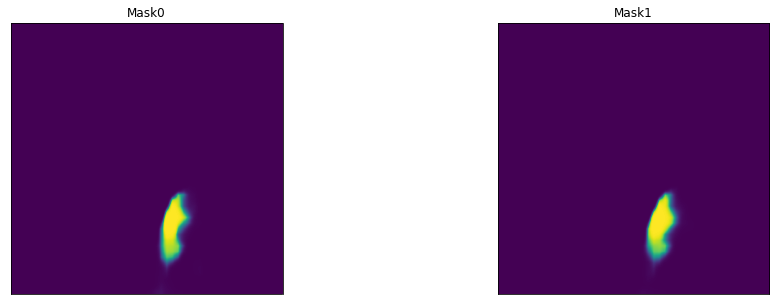

In [ ]:

img = imageio.imread(image_path) # novel image
tempo=Huymodel.predict(img)
mask1=cv2.resize(tempo.squeeze(),list(img.shape[:-1:][::-1]))

#mask[mask>=0.5]=0
#mask[mask!=0]=1
#img=denormalize(img.squeeze())



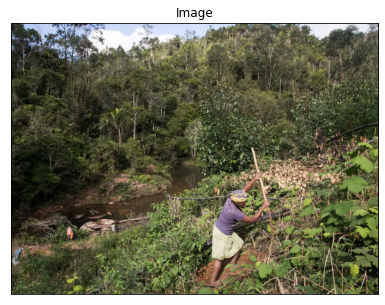

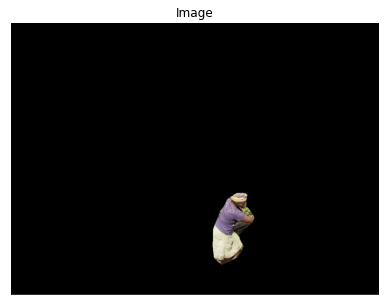

In [ ]:
#@title After running this cell manually, it will auto-run if you change the selected value. { run: "auto" }

cut_out1=img.copy()
mask_out=processMask(mask1.copy())
threshold = 0.4 #@param {type:"slider", min:0.1, max:1, step:0.01}

cut_out1[mask1<=threshold]=0

visualize(
        image=img,
)
visualize(
        image=cut_out1,
)
        #pr_mask=mask,
        #cut_out=cut_out)

# Khang Visualize


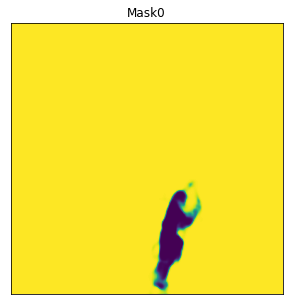

In [ ]:

img = imageio.imread(image_path) # novel image
tempo=Khangmodel.predict(img)
mask=cv2.resize(tempo.squeeze(),list(img.shape[:-1:][::-1]))

mask2=np.max(mask)-mask
#mask[mask!=0]=1
#img=denormalize(img.squeeze())



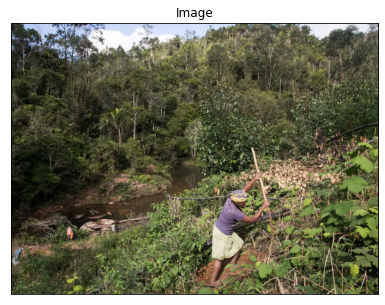

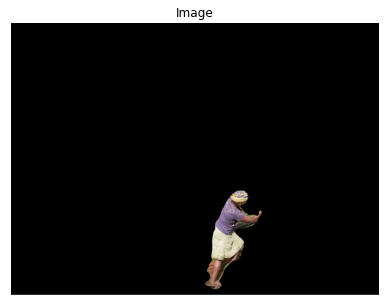

In [ ]:
#@title After running this cell manually, it will auto-run if you change the selected value. { run: "auto" }

cut_out2=img.copy()
mask_out=processMask(mask2.copy())
threshold = 0.53 #@param {type:"slider", min:0.1, max:1, step:0.01}

cut_out2[mask2<=threshold]=0

visualize(
        image=img,
)
visualize(
        image=cut_out2,
)
        #pr_mask=mask,
        #cut_out=cut_out)

# Tuấn Visualize

In [ ]:
data_dict2=[{"image":image_path, "label": image_path}]
ds_img_test = DataReader(data=data_dict2, transform=val_aug)
loader_img_test=DataLoader(ds_img_test, batch_size=1, shuffle=True,num_workers=4)
batch_=  next(iter(loader_img_test))
with torch.no_grad():
    model_load.eval()
    logits = model_load(batch_[0])
pr_masks = logits.sigmoid()
for image, pr_mask in zip(batch_[0], pr_masks):
    image=image.numpy().transpose(1, 2, 0)
    pr_mask=pr_mask.numpy().squeeze()
cutout3=image.copy()
cutout3[pr_mask<=0.1]=0

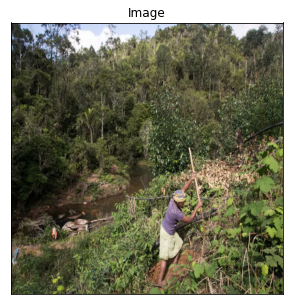

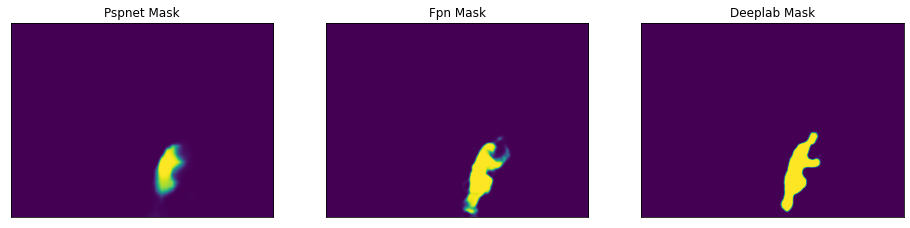

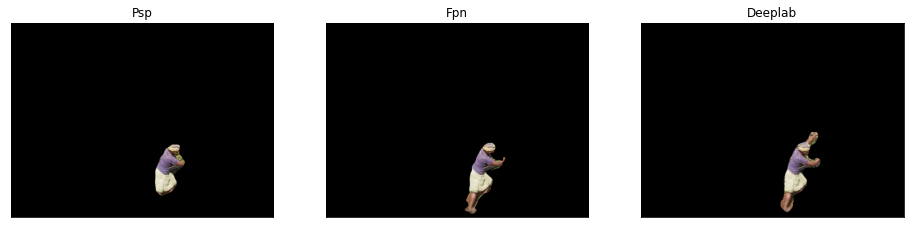

In [ ]:
visualize(
    image=image,
)
visualize(
    PSPNet_mask=mask1,
    FPN_mask=mask2,
    Deeplab_mask=cv2.resize(pr_mask,list(mask2.shape[::][::-1]))
)
cutout3=cv2.resize(cutout3,list(cut_out2.shape[:-1:][::-1]))
visualize(
    PSP=cut_out1,
    FPN=cut_out2,
    Deeplab=cutout3,
    
)